In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import save_model, load_model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = 'drive/MyDrive/ProjetPattern/'

Mounted at /content/drive


In [ ]:
def split_image_into_puzzle_pieces(image, puzzle_size):
    width, height = image.size
    puzzle_pieces = []
    
    for y in range(0, height, puzzle_size):
        for x in range(0, width, puzzle_size):
            piece = image.crop((x, y, x + puzzle_size, y + puzzle_size))
            puzzle_pieces.append(piece)
    
    return puzzle_pieces

def augment_data(dataset, labels):
    augmented_data = []
    augmented_labels = []

    for num in range (0, dataset.shape[0]):
        # original image:
        augmented_data.append(dataset[num])
        augmented_labels.append(labels[num])

        # rotation 90
        augmented_data.append(np.rot90(dataset[num], 1))
        augmented_labels.append(labels[num])

        # rotation 180
        augmented_data.append(np.rot90(dataset[num], 2))
        augmented_labels.append(labels[num])

        # rotation 270
        augmented_data.append(np.rot90(dataset[num], 3))
        augmented_labels.append(labels[num])

    return np.array(augmented_data), np.array(augmented_labels)


In [ ]:
folder="train_solutions"
path = data_path+"data_project"
puzzle_size=128

files = os.listdir(os.path.join(path, folder))
solution_files = [file for file in files if file.startswith("solution")]

puzzle_array = []
labels = []
label_list_folder = os.path.join(data_path, "labels_list")  # Folder to store one image per label

for image_index, filename in enumerate(solution_files):
    path_solution = os.path.join(path, folder, filename)

    im = Image.open(path_solution).convert('RGB')

    puzzle_pieces = split_image_into_puzzle_pieces(im, puzzle_size)

    puzzle_array.extend([np.array(piece) for piece in puzzle_pieces])
    labels.extend([image_index] * len(puzzle_pieces))

    # Write the full image corresponding to each unique label to the label_list folder
    if not os.path.exists(label_list_folder):
        os.makedirs(label_list_folder)

    if image_index not in labels[:image_index]:
        im.save(os.path.join(label_list_folder, f"label_{image_index}.jpg"))

puzzle_array = np.array(puzzle_array)
labels = np.array(labels)

# Apply the function to your data
puzzle_array, labels = augment_data(puzzle_array, labels)

# Shuffle the data
puzzle_array, labels = shuffle(puzzle_array, labels, random_state=42)

# Assuming your input shape is (128, 128, 3)
input_shape = (128, 128, 3)

In [ ]:
print(puzzle_array.shape)
print(labels.shape)

(1808, 128, 128, 3)
(1808,)


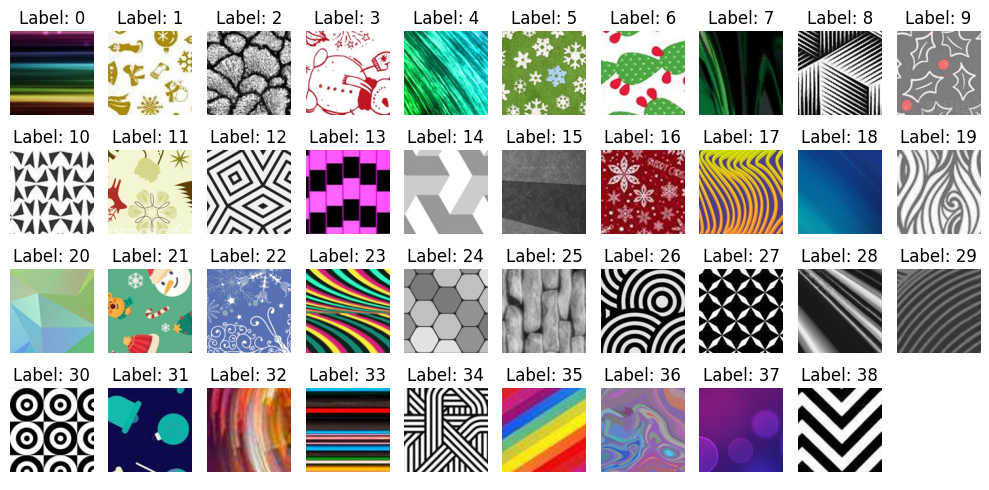

In [ ]:
unique_labels = np.unique(labels)  # Get unique labels

num_images = len(unique_labels)
num_cols = min(num_images, 10)  # Set the maximum number of columns to 4

num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))  # Create a figure and subplots

for i, label in enumerate(unique_labels):
    image_index = np.where(labels == label)[0][0]  # Find the index of the first image with the current label
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(puzzle_array[image_index])
    ax.set_title(f"Label: {label}")
    ax.axis('off')

# Hide any unused subplots
for i in range(num_images,num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Find unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)

test_data = []
test_labels = []

# Loop over each unique label
for label in unique_labels:
    # Get the indices for each occurrence of the current label
    label_indices = np.where(labels == label)[0]
    
    # Randomly shuffle these indices
    np.random.shuffle(label_indices)
    
    # Split indices into test (first 2) and train (remaining)
    test_indices = label_indices[:2]
    
    # Add corresponding data and labels to test and train lists
    test_data.append(puzzle_array[test_indices])
    test_labels.append(labels[test_indices])

# Convert lists to numpy arrays
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [ ]:
print(test_data.shape)

(78, 128, 128, 3)


In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

input_shape = (128, 128, 3)

model = Sequential([
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(40, activation='softmax')
])


# set up learning rate decay
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

opt = Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#history = model.fit(puzzle_array, labels, epochs=100, validation_split=0.1)

In [ ]:
"""# Plot the evolution of training and validation metrics (accuracy and loss)
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)"""

"# Plot the evolution of training and validation metrics (accuracy and loss)\ndef plot_metrics(history):\n    plt.figure(figsize=(12, 4))\n\n    # Plot accuracy\n    plt.subplot(1, 2, 1)\n    plt.plot(history.history['accuracy'], label='Training Accuracy')\n    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')\n    plt.title('Accuracy')\n    plt.xlabel('Epoch')\n    plt.ylabel('Accuracy')\n    plt.legend()\n\n    # Plot loss\n    plt.subplot(1, 2, 2)\n    plt.plot(history.history['loss'], label='Training Loss')\n    plt.plot(history.history['val_loss'], label='Validation Loss')\n    plt.title('Loss')\n    plt.xlabel('Epoch')\n    plt.ylabel('Loss')\n    plt.legend()\n\n    plt.tight_layout()\n    plt.show()\n\nplot_metrics(history)"

In [ ]:
# Save the model
#model.save(data_path +"full_dataV2.h5")

In [ ]:
# Load the model
loaded_model = load_model(data_path+"full_dataV2.h5")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Evaluate the model on the training data
test_loss, test_accuracy = loaded_model.evaluate(test_data, test_labels)

print("Training Loss:", test_loss)
print("Training Accuracy:", test_accuracy)


3/3 [==============================] - 9s 379ms/step - loss: 1.8005e-04 - accuracy: 1.0000
Training Loss: 0.00018004882440436631
Training Accuracy: 1.0


57/57 [==============================] - 2s 40ms/step


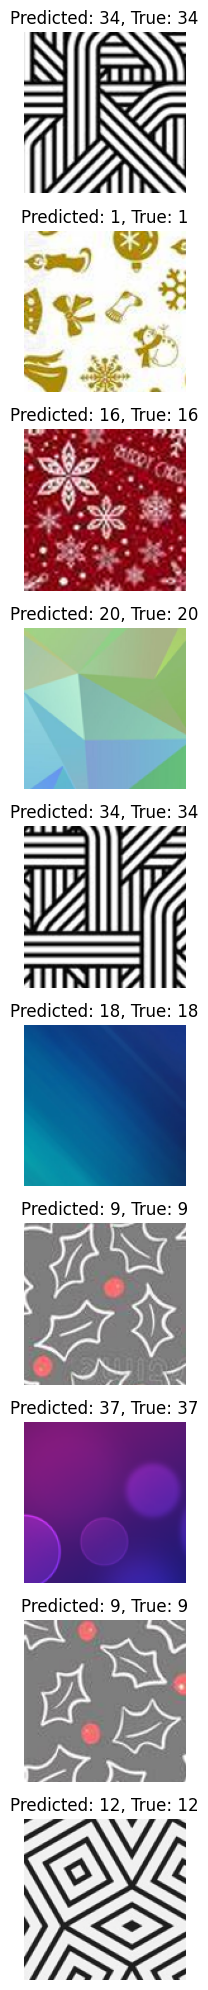

In [ ]:
# Make predictions on the training data
predictions = loaded_model.predict(puzzle_array)
predicted_labels = np.argmax(predictions, axis=1)

# Select a subset of data for plotting (e.g., first 10 samples)
num_samples = 10
subset_puzzle_array = puzzle_array[:num_samples]
subset_labels = labels[:num_samples]
subset_predicted_labels = predicted_labels[:num_samples]

# Plot the images with predicted and correct labels
fig, axes = plt.subplots(nrows=num_samples, figsize=(10, 2*num_samples))
for i, (image, pred_label, true_label) in enumerate(zip(subset_puzzle_array, subset_predicted_labels, subset_labels)):
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {pred_label}, True: {true_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
